In [358]:
# importing the csv files 
import pandas as pd
import matplotlib.pyplot as plt

df_amazon = pd.read_csv('amazon_data.csv')
df_coke = pd.read_csv('coke_data.csv')
df_jnj = pd.read_csv('j&j_data.csv')

In [359]:
df_amazon.head()
 

,Date,Open,High,Low,Close,Volume
0,2025-03-14T15:00:00.000Z,197.60,198.57,197.40,198.11,424006
1,2025-03-14T14:00:00.000Z,197.20,198.01,196.94,197.63,105407
2,2025-03-14T13:00:00.000Z,198.15,198.47,197.04,197.18,107892
3,2025-03-14T12:00:00.000Z,197.76,198.44,196.77,198.25,122777
4,2025-03-14T11:00:00.000Z,197.57,198.25,197.02,197.71,175457


In [360]:
# convert the "Date" column to a date and hour format with to_datetime() and creating separate columns
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])
 
df_amazon['date'] = df_amazon['Date'].dt.date
df_amazon['hour'] = df_amazon['Date'].dt.hour

df_amazon = df_amazon.drop(columns=['Date'])
 
df_amazon.head()

print(df_amazon)



       Open    High     Low   Close  Volume        date  hour
0    197.60  198.57  197.40  198.11  424006  2025-03-14    15
1    197.20  198.01  196.94  197.63  105407  2025-03-14    14
2    198.15  198.47  197.04  197.18  107892  2025-03-14    13
3    197.76  198.44  196.77  198.25  122777  2025-03-14    12
4    197.57  198.25  197.02  197.71  175457  2025-03-14    11
..      ...     ...     ...     ...     ...         ...   ...
893  186.65  187.14  186.52  186.85   57807  2024-09-18    13
894  185.75  186.75  185.65  186.66   48245  2024-09-18    12
895  187.08  187.25  185.68  185.75   84873  2024-09-18    11
896  186.58  187.40  186.26  187.10   91530  2024-09-18    10
897  186.50  186.76  185.06  186.58   91259  2024-09-18     9

[898 rows x 7 columns]


In [361]:
#here I'm flipping the data so we don't need to read data from bottom up 

df_amazon = df_amazon.iloc[::-1]
df_amazon = df_amazon.reset_index(drop=True)
#print to check

print(df_amazon)

       Open    High     Low   Close  Volume        date  hour
0    186.50  186.76  185.06  186.58   91259  2024-09-18     9
1    186.58  187.40  186.26  187.10   91530  2024-09-18    10
2    187.08  187.25  185.68  185.75   84873  2024-09-18    11
3    185.75  186.75  185.65  186.66   48245  2024-09-18    12
4    186.65  187.14  186.52  186.85   57807  2024-09-18    13
..      ...     ...     ...     ...     ...         ...   ...
893  197.57  198.25  197.02  197.71  175457  2025-03-14    11
894  197.76  198.44  196.77  198.25  122777  2025-03-14    12
895  198.15  198.47  197.04  197.18  107892  2025-03-14    13
896  197.20  198.01  196.94  197.63  105407  2025-03-14    14
897  197.60  198.57  197.40  198.11  424006  2025-03-14    15

[898 rows x 7 columns]


In [362]:

split_index = (len(df_amazon) - 1) // 2

# separate half to train later on and one for testing results
df_train_amazon = df_amazon.iloc[:split_index + 1].reset_index(drop=True)
df_test_amazon = df_amazon.iloc[split_index + 1:].reset_index(drop=True)

print(df_train_amazon)

print(df_test_amazon)

       Open    High     Low   Close  Volume        date  hour
0    186.50  186.76  185.06  186.58   91259  2024-09-18     9
1    186.58  187.40  186.26  187.10   91530  2024-09-18    10
2    187.08  187.25  185.68  185.75   84873  2024-09-18    11
3    185.75  186.75  185.65  186.66   48245  2024-09-18    12
4    186.65  187.14  186.52  186.85   57807  2024-09-18    13
..      ...     ...     ...     ...     ...         ...   ...
444  229.50  230.42  229.49  230.21  199910  2024-12-11    15
445  230.23  230.23  230.16  230.23     400  2024-12-11    16
446  229.53  230.26  227.64  228.78  193023  2024-12-12     9
447  228.75  230.82  228.08  230.45  167628  2024-12-12    10
448  230.43  231.07  229.29  229.79   97899  2024-12-12    11

[449 rows x 7 columns]
       Open    High     Low   Close  Volume        date  hour
0    229.84  230.48  229.53  230.24   71633  2024-12-12    12
1    230.24  230.34  229.54  229.55   46449  2024-12-12    13
2    229.51  229.74  228.60  228.69   51818  2

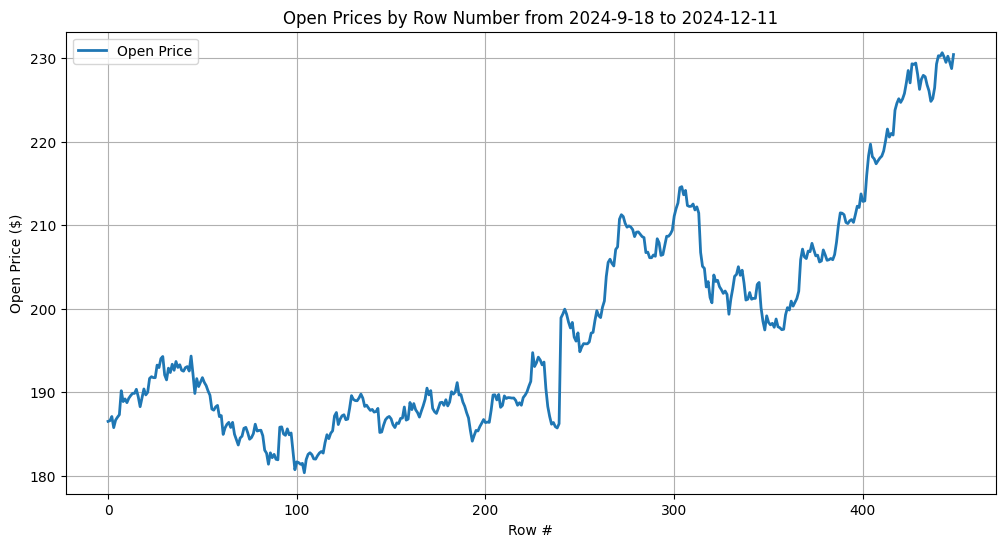

In [363]:

plt.figure(figsize=(12, 6))
plt.plot(df_train_amazon.index, df_train_amazon['Open'], label='Open Price', linewidth=2)

plt.xlabel('Row #')
plt.ylabel('Open Price ($)')
plt.title('Open Prices by Row Number from 2024-9-18 to 2024-12-11')
plt.grid(True)
plt.legend()
plt.show()

0.8604948042185597


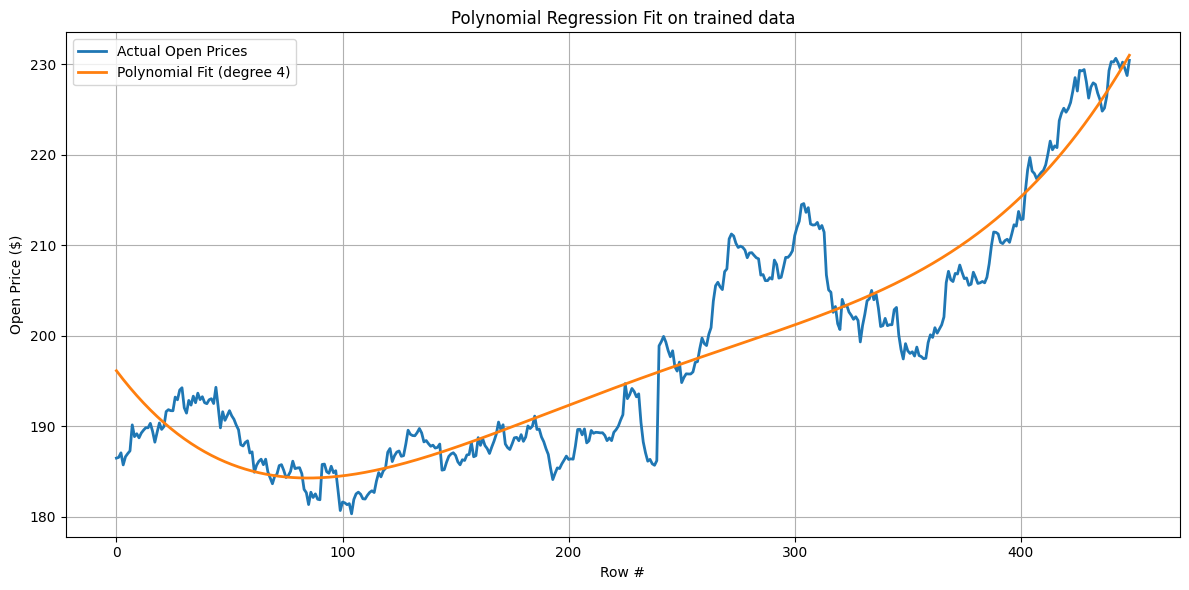

In [364]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# set x and y
X = df_train_amazon.index.to_numpy().reshape(-1, 1)
y = df_train_amazon['Open'].to_numpy()

# set polynomial regression degree
degree = 4
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(X, y)

# Predict the Open prices 
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(r2)
# Plot it
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Actual Open Prices', linewidth=2)
plt.plot(X, y_pred, label=f'Polynomial Fit (degree {degree})', linewidth=2)

plt.xlabel('Row #')
plt.ylabel('Open Price ($)')
plt.title('Polynomial Regression Fit on trained data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


degree 3 84.04

degree 4 86.05

degree 5 90.

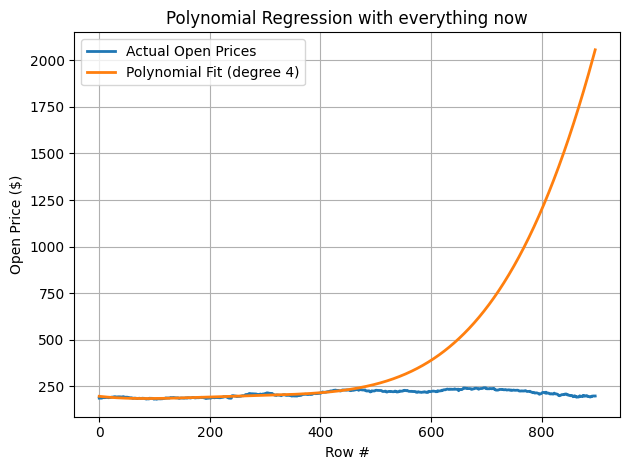

In [365]:
# now let see how it fits with the rest of the data
x_every = df_amazon.index.to_numpy().reshape(-1, 1)
y_every = df_amazon['Open'].to_numpy()

y_pred_half = model.predict(x_every)

plt.plot(x_every, y_every, label='Actual Open Prices', linewidth=2)
plt.plot(x_every, y_pred_half, label=f'Polynomial Fit (degree {degree})', linewidth=2)

plt.xlabel('Row #')
plt.ylabel('Open Price ($)')
plt.title('Polynomial Regression with everything now')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

This is a failed example as you can see from the top but what i can do is make a for loop where everytime it predicts the next hour and once next hour hits 

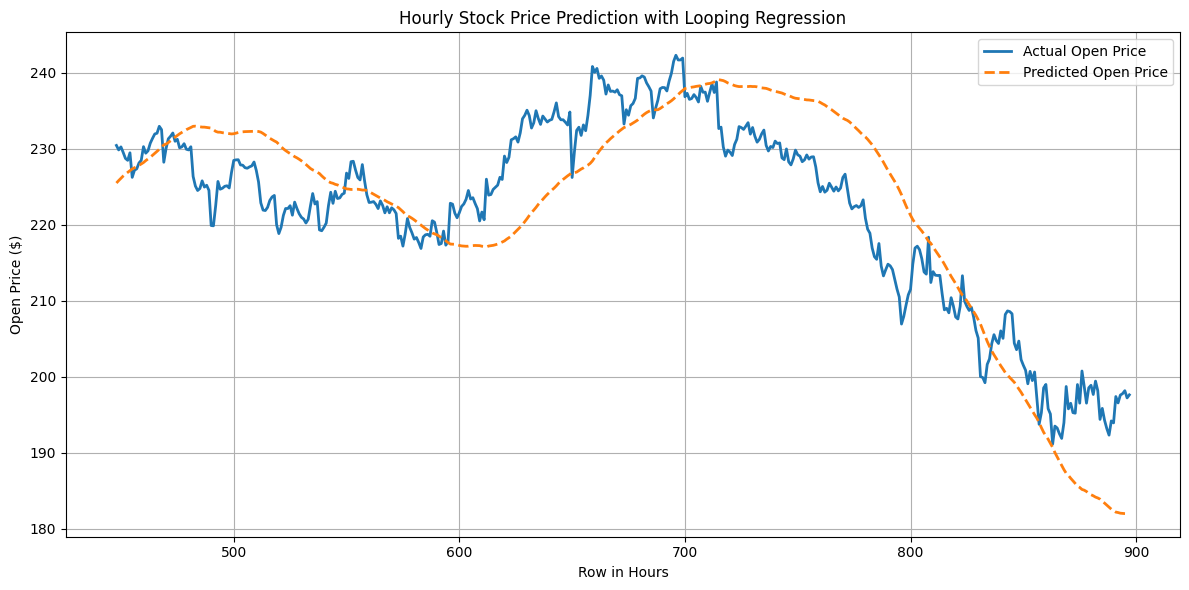

In [ ]:
start_size = (len(df_amazon) - 1) // 2

predictions = []    
actuals = [] 

for i in range(start_size, len(df_amazon)):
    train_data = df_amazon.iloc[i - start_size:i]
    X_train = np.arange(start_size).reshape(-1, 1)
    y_train = train_data['Open'].to_numpy()  
    
    # linear
    #model = LinearRegression()
    #model.fit(X_train, y_train)

    degree = 3  
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # Predict the next hour
    next_index = np.array([[start_size]])  # the next index after the training window
    pred = model.predict(next_index)
    
    # Save the prediction and the actual value
    predictions.append(pred[0])
    actuals.append(df_amazon.iloc[i]['Open'])

results = pd.DataFrame({
    'Actual_Open': actuals,
    'Predicted_Open': predictions
}, index=df_amazon.index[start_size:])

plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual_Open'], label='Actual Open Price', linewidth=2)
plt.plot(results.index, results['Predicted_Open'], label='Predicted Open Price', linestyle='--', linewidth=2)
plt.xlabel('Row in Hours')
plt.ylabel('Open Price ($)')
plt.title('Hourly Stock Price Prediction with Looping Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

